### Download the package
```pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"```

In [1]:
import math
import os
import random

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import Trainer, TrainingArguments
from transformers.integrations import INTEGRATION_TO_CALLBACK

from tsfm_public import (
    TimeSeriesPreprocessor,
    TrackingCallback,
    count_parameters,
    get_datasets,
)
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
from tsfm_public.toolkit.time_series_preprocessor import DEFAULT_FREQUENCY_MAPPING

### Load data

In [2]:
from src.data.diabetes_datasets.kaggle_bris_t1d.bris_t1d import BrisT1DDataLoader

loader = BrisT1DDataLoader(use_cached=True)
# TODO:TONY - Not sure why it is still processing even if use_cached is True

INFO:p-40208:t-8767966336:bris_t1d.py:load_data:============================================================
INFO:p-40208:t-8767966336:bris_t1d.py:load_data:Beginning data loading process with the following parmeters:
INFO:p-40208:t-8767966336:bris_t1d.py:load_data:	Dataset: kaggle_brisT1D - train
INFO:p-40208:t-8767966336:bris_t1d.py:load_data:	Columns: None
INFO:p-40208:t-8767966336:bris_t1d.py:load_data:	Generic patient start date: 2024-01-01 00:00:00
INFO:p-40208:t-8767966336:bris_t1d.py:load_data:	Number of validation days: 20
INFO:p-40208:t-8767966336:bris_t1d.py:load_data:	In parallel with up to 3 workers.

INFO:p-40208:t-8767966336:cache_manager.py:get_processed_data_path:Processed data path for kaggle_brisT1D: /Users/tonychan/GlucoseML/nocturnal-hypo-gly-prob-forecast/cache/data/kaggle_brisT1D/processed


INFO:p-40208:t-8767966336:bris_t1d.py:load_data:Loaded full processed data from cache for 9 patients
INFO:p-40208:t-8767966336:cache_manager.py:get_processed_data_path:Processed data path for kaggle_brisT1D: /Users/tonychan/GlucoseML/nocturnal-hypo-gly-prob-forecast/cache/data/kaggle_brisT1D/processed
INFO:p-40208:t-8767966336:bris_t1d.py:_split_train_validation:Loaded existing train/validation split from cache for 9 patients


### Arguments configuration

In [3]:
# Try out r1 too
# This can also be a path to a checkpoint
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"


# 100 for full-shot
FEWSHOT_PERCENT = 100
CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96

# Which resolution to train on (15 or 5)
RESOLUTION_MIN = 5

current_time = pd.Timestamp.now().strftime("%Y-%m-%d_%H-%M-%S")
interval = f"{RESOLUTION_MIN}mins"

# Where to save the checkpoint
OUT_DIR = f"../../models/ttm/kaggle_brisT1D/{interval}/{current_time}"

### Data processing for ttm

In [4]:
from src.tuning.benchmark import impute_missing_values

y_feature = ["bg_mM"]
x_features = ["steps", "cob", "carb_availability", "insulin_availability", "iob"]

# datetime is the index column...
timestamp_column = "datetime"

# exogenous features
column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": ["id"],
    "target_columns": y_feature,
    "control_columns": x_features,
}

data_dict = loader.processed_data


def reduce_features_multi_patient(patients_dict, interval=RESOLUTION_MIN):
    """
    Process each patient's data separately to avoid datetime index issues
    """
    processed_patients = []

    for patient_id, df in patients_dict.items():
        # Check if patient has the correct interval
        if (df.index[1] - df.index[0]).components.minutes == interval:
            print(f"Processing patient {patient_id}...")
            # Process each patient individually
            p_df = df.iloc[:]
            p_df = p_df[x_features + y_feature]
            # Impute missing values for this patient
            p_df = impute_missing_values(p_df, columns=x_features)
            p_df = impute_missing_values(p_df, columns=y_feature)
            p_df["id"] = patient_id
            processed_patients.append(p_df)

    return pd.concat(processed_patients)


# Use this instead of combining all patients first
all_patients_df = reduce_features_multi_patient(data_dict)

# datetime has to be a column
data = all_patients_df.reset_index()

# Train/val/test split
data_length = len(data)
split_config = {
    "train": 0.7,  # 70% for training
    "test": 0.2,  # 20% for testing (10% auto-assigned to validation)
}
print(data["id"].unique())

Processing patient p04...
Processing patient p12...
Processing patient p03...
Processing patient p02...
Processing patient p10...
Processing patient p11...
['p04' 'p12' 'p03' 'p02' 'p10' 'p11']


## Few-shot / Full-shot settings

In [ ]:
def get_finetune_trainer(
    dataset_name,
    model_path,
    batch_size,  # TODO:TONY - This will need to be dynamic
    learning_rate=None,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    fewshot_percent=5,
    freeze_backbone=True,
    num_epochs=50,
    save_dir=OUT_DIR,
    loss="mse",  # TODO:TONY - Try out Pinball loss too
    quantile=0.5,
    use_cpu=False,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    finetune_forecast_model = get_model(
        model_path,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=DEFAULT_FREQUENCY_MAPPING[f"{RESOLUTION_MIN}min"],
        prefer_l1_loss=False,
        prefer_longer_context=True,
        # Can also provide TTM Config args
        loss=loss,
        quantile=quantile,
    )

    # TODO:TONY - Pull this out of the function
    # TODO:TONY - Check the shape of this function
    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="last",  # Take the last x percent of the training data
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
    )

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=100,
        logging_dir=os.path.join(
            out_dir, "logs"
        ),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        use_cpu=use_cpu,
    )

    # Create the early stopping callback
    # early_stopping_callback = EarlyStoppingCallback(
    #     early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    #     early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    # )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[
            # TODO:TONY - Remove early stopping for now
            # early_stopping_callback,
            tracking_callback
        ],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    return finetune_forecast_trainer, dset_test


# From the doc string, I think this is the percentage of the training data to use for few shot finetuning
dataset_name = f"{RESOLUTION_MIN}min_patients"
finetune_forecast_trainer, dset_test = get_finetune_trainer(
    model_path=TTM_MODEL_PATH,
    dataset_name=dataset_name,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=FEWSHOT_PERCENT,
    learning_rate=0.001,
    save_dir=OUT_DIR,
)

INFO:p-40208:t-8767966336:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------


INFO:p-40208:t-8767966336:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-40208:t-8767966336:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


### Start the finetune

In [9]:
### Fine-tune
finetune_forecast_trainer.train()

{'loss': 0.8596, 'grad_norm': 0.5748658776283264, 'learning_rate': 5.0489998773502296e-05, 'epoch': 1.0}
{'eval_loss': 0.8879503607749939, 'eval_runtime': 69.6458, 'eval_samples_per_second': 215.246, 'eval_steps_per_second': 3.374, 'epoch': 1.0}
{'loss': 0.8377, 'grad_norm': 0.4806883931159973, 'learning_rate': 8.150149478455891e-05, 'epoch': 2.0}
{'eval_loss': 0.8808636665344238, 'eval_runtime': 69.3982, 'eval_samples_per_second': 216.014, 'eval_steps_per_second': 3.386, 'epoch': 2.0}
{'loss': 0.8298, 'grad_norm': 0.7164957523345947, 'learning_rate': 0.00013167902738683466, 'epoch': 3.0}
{'eval_loss': 0.8772957921028137, 'eval_runtime': 70.7651, 'eval_samples_per_second': 211.842, 'eval_steps_per_second': 3.321, 'epoch': 3.0}
{'loss': 0.8238, 'grad_norm': 0.4873969852924347, 'learning_rate': 0.0001988294205159325, 'epoch': 4.0}
{'eval_loss': 0.8743990659713745, 'eval_runtime': 70.2361, 'eval_samples_per_second': 213.437, 'eval_steps_per_second': 3.346, 'epoch': 4.0}
{'loss': 0.8197, '

TrainOutput(global_step=82250, training_loss=0.7872401275170973, metrics={'train_runtime': 14879.2897, 'train_samples_per_second': 353.68, 'train_steps_per_second': 5.528, 'train_loss': 0.7872401275170973, 'epoch': 50.0})

### Evaluate

In [11]:
# Evaluation
print("+" * 20, f"Test MSE after few-shot {FEWSHOT_PERCENT}% fine-tuning", "+" * 20)
finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
print(fewshot_output)
print("+" * 60)

++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++
{'eval_loss': 0.9574525952339172, 'eval_runtime': 79.7012, 'eval_samples_per_second': 383.169, 'eval_steps_per_second': 5.997, 'epoch': 50.0}
{'eval_loss': 0.9574525952339172, 'eval_runtime': 79.7012, 'eval_samples_per_second': 383.169, 'eval_steps_per_second': 5.997, 'epoch': 50.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


### Predict

In [ ]:
# get predictions
predictions_dict = finetune_forecast_trainer.predict(dset_test)
predictions_np = predictions_dict.predictions[0]
print(predictions_np.shape)

# get backbone embeddings (if needed for further analysis)
backbone_embedding = predictions_dict.predictions[1]
print(backbone_embedding.shape)


# plot
random.seed(42)  # For reproducibility
test_dataset_size = len(dset_test)
valid_indices = random.sample(range(test_dataset_size), min(10, test_dataset_size))
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=dset_test,
    plot_dir=os.path.join(OUT_DIR, dataset_name),
    plot_prefix="test_fewshot",
    indices=valid_indices,
    channel=0,
)

: 

### Eval_loss vs epochs

Total epochs: 7
Epoch range: 1.0 to 7.0
Loss range: 0.8722 to 0.8880
Final loss: 0.8722


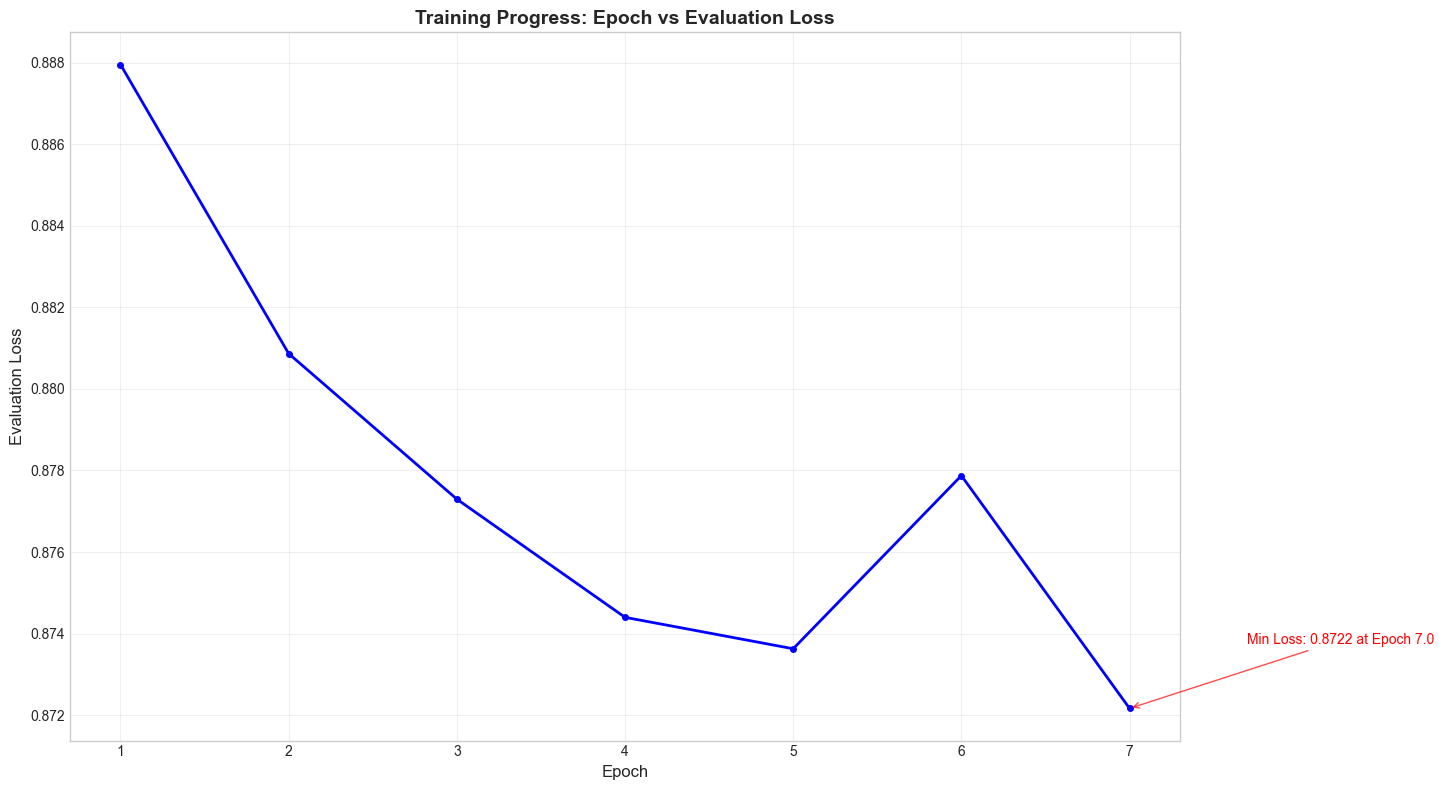

In [141]:
import os
import json
import matplotlib.pyplot as plt

checkpoint_dirs = []


latest_checkpoint = (
    "../../models/ttm/15mins/2025-09-27_16-05-09/5min_patients/output/checkpoint-11515"
)

trainer_state = json.load(open(os.path.join(latest_checkpoint, "trainer_state.json")))
log_history = trainer_state["log_history"]
epochs = []
eval_losses = []

for entry in log_history:
    if "epoch" in entry and "eval_loss" in entry:
        epochs.append(entry["epoch"])
        eval_losses.append(entry["eval_loss"])

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, eval_losses, "b-", linewidth=2, marker="o", markersize=4)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Evaluation Loss", fontsize=12)
plt.title("Training Progress: Epoch vs Evaluation Loss", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Add some statistics
min_loss = min(eval_losses)
min_epoch = epochs[eval_losses.index(min_loss)]
plt.annotate(
    f"Min Loss: {min_loss:.4f} at Epoch {min_epoch}",
    xy=(min_epoch, min_loss),
    xytext=(
        min_epoch + len(epochs) * 0.1,
        min_loss + (max(eval_losses) - min(eval_losses)) * 0.1,
    ),
    arrowprops=dict(arrowstyle="->", color="red", alpha=0.7),
    fontsize=10,
    color="red",
)

print(f"Total epochs: {len(epochs)}")
print(f"Epoch range: {min(epochs)} to {max(epochs)}")
print(f"Loss range: {min(eval_losses):.4f} to {max(eval_losses):.4f}")
print(f"Final loss: {eval_losses[-1]:.4f}")

plt.show()

### Load from a checkpoint

In [ ]:
# Load from checkpoint

model = get_model(
    "../../models/ttm/15mins/2025-09-27_16-05-09/5min_patients/output/checkpoint-11515",  # Direct checkpoint path
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
)

random.seed(42)  # For reproducibility
test_dataset_size = len(dset_test)
valid_indices = random.sample(range(test_dataset_size), min(10, test_dataset_size))
plot_predictions(
    model=finetune_forecast_trainer.model,
    dset=dset_test,
    plot_dir=os.path.join(OUT_DIR, dataset_name),
    plot_prefix="test_fewshot",
    indices=valid_indices,
    channel=0,
)

INFO:p-1546:t-8767966336:get_model.py:get_model:Loading model from: ../../models/ttm/15mins/2025-09-27_16-05-09/5min_patients/output/checkpoint-11515
INFO:p-1546:t-8767966336:get_model.py:get_model:Model loaded successfully from ../../models/ttm/15mins/2025-09-27_16-05-09/5min_patients/output/checkpoint-11515, revision = None.
INFO:p-1546:t-8767966336:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96
